In [1]:
from pathlib import Path

# Dataset is directly in data/raw
DATA_ROOT = Path('../data/raw')

print('Dataset root:', DATA_ROOT.resolve())
print('Dataset exists:', DATA_ROOT.exists())
print('Train images:', (DATA_ROOT/'train/images').exists())
print('Train labels:', (DATA_ROOT/'train/labels').exists())
print('Valid images:', (DATA_ROOT/'valid/images').exists())
print('Test images:', (DATA_ROOT/'test/images').exists())


Dataset root: C:\Users\ynver\pcb-defect-detection\data\raw
Dataset exists: True
Train images: True
Train labels: True
Valid images: True
Test images: True


In [2]:
from pathlib import Path

DATA_ROOT = Path('../data/raw')  # already confirmed
SPLITS = ['train', 'valid', 'test']

for split in SPLITS:
    img_dir = DATA_ROOT / split / 'images'
    label_dir = DATA_ROOT / split / 'labels'
    img_count = len(list(img_dir.glob('*.jpg'))) + len(list(img_dir.glob('*.png')))
    label_count = len(list(label_dir.glob('*.txt')))
    print(f"{split.capitalize()}: {img_count} images, {label_count} label files")


Train: 522 images, 522 label files
Valid: 48 images, 48 label files
Test: 38 images, 38 label files


In [3]:
import pandas as pd
from pathlib import Path

DATA_ROOT = Path('../data/raw')

# Read data.yaml to get class names
import yaml
with open(DATA_ROOT / 'data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
num_classes = len(class_names)

print(f"Dataset has {num_classes} defect classes:")
for i, name in enumerate(class_names):
    print(f"  Class {i}: {name}")


Dataset has 7 defect classes:
  Class 0: defect1
  Class 1: defect2
  Class 2: defect3
  Class 3: defect4
  Class 4: defect5
  Class 5: defect6
  Class 6: defect7


In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_ROOT = Path('../data/raw')
TRAIN_LABELS = DATA_ROOT / 'train' / 'labels'

# Count instances of each class
class_counts = [0] * 7  # 7 classes

for label_file in TRAIN_LABELS.glob('*.txt'):
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts:  # Check line is not empty
                class_id = int(parts[0])
                class_counts[class_id] += 1

# Create results table
class_names = ['defect1', 'defect2', 'defect3', 'defect4', 'defect5', 'defect6', 'defect7']
total_instances = sum(class_counts)

print("=" * 60)
print("CLASS DISTRIBUTION IN TRAINING SET")
print("=" * 60)
for i, (name, count) in enumerate(zip(class_names, class_counts)):
    percentage = (count / total_instances) * 100
    print(f"Class {i} ({name}): {count:4d} instances ({percentage:5.2f}%)")
print("=" * 60)
print(f"TOTAL DEFECTS: {total_instances}")
print("=" * 60)


CLASS DISTRIBUTION IN TRAINING SET
Class 0 (defect1):  570 instances (20.34%)
Class 1 (defect2):  402 instances (14.35%)
Class 2 (defect3):  354 instances (12.63%)
Class 3 (defect4):  312 instances (11.13%)
Class 4 (defect5):  549 instances (19.59%)
Class 5 (defect6):  333 instances (11.88%)
Class 6 (defect7):  282 instances (10.06%)
TOTAL DEFECTS: 2802


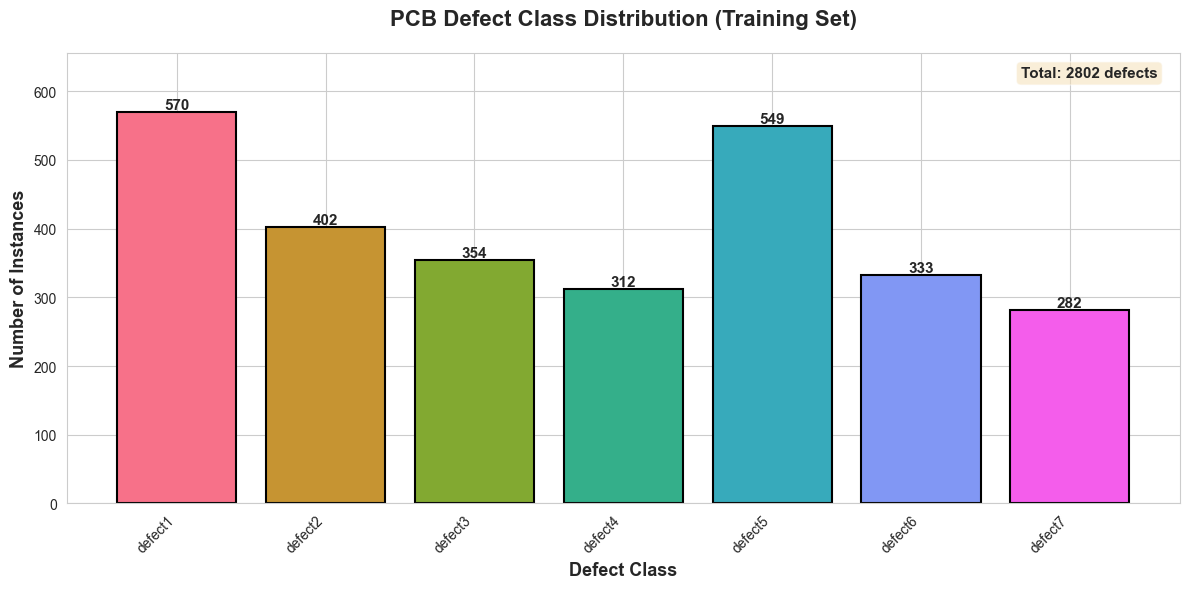

✅ Class distribution chart created!


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Data from previous cell
class_names = ['defect1', 'defect2', 'defect3', 'defect4', 'defect5', 'defect6', 'defect7']
class_counts = [570, 402, 354, 312, 549, 333, 282]

# Create bar chart
colors = sns.color_palette("husl", 7)
bars = plt.bar(class_names, class_counts, color=colors, edgecolor='black', linewidth=1.5)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Styling
plt.title('PCB Defect Class Distribution (Training Set)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Defect Class', fontsize=13, fontweight='bold')
plt.ylabel('Number of Instances', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(class_counts) * 1.15)  # Add space for labels
plt.tight_layout()

# Add total annotation
plt.text(0.98, 0.97, f'Total: {sum(class_counts)} defects', 
         transform=plt.gca().transAxes, 
         fontsize=11, fontweight='bold',
         ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

print("✅ Class distribution chart created!")


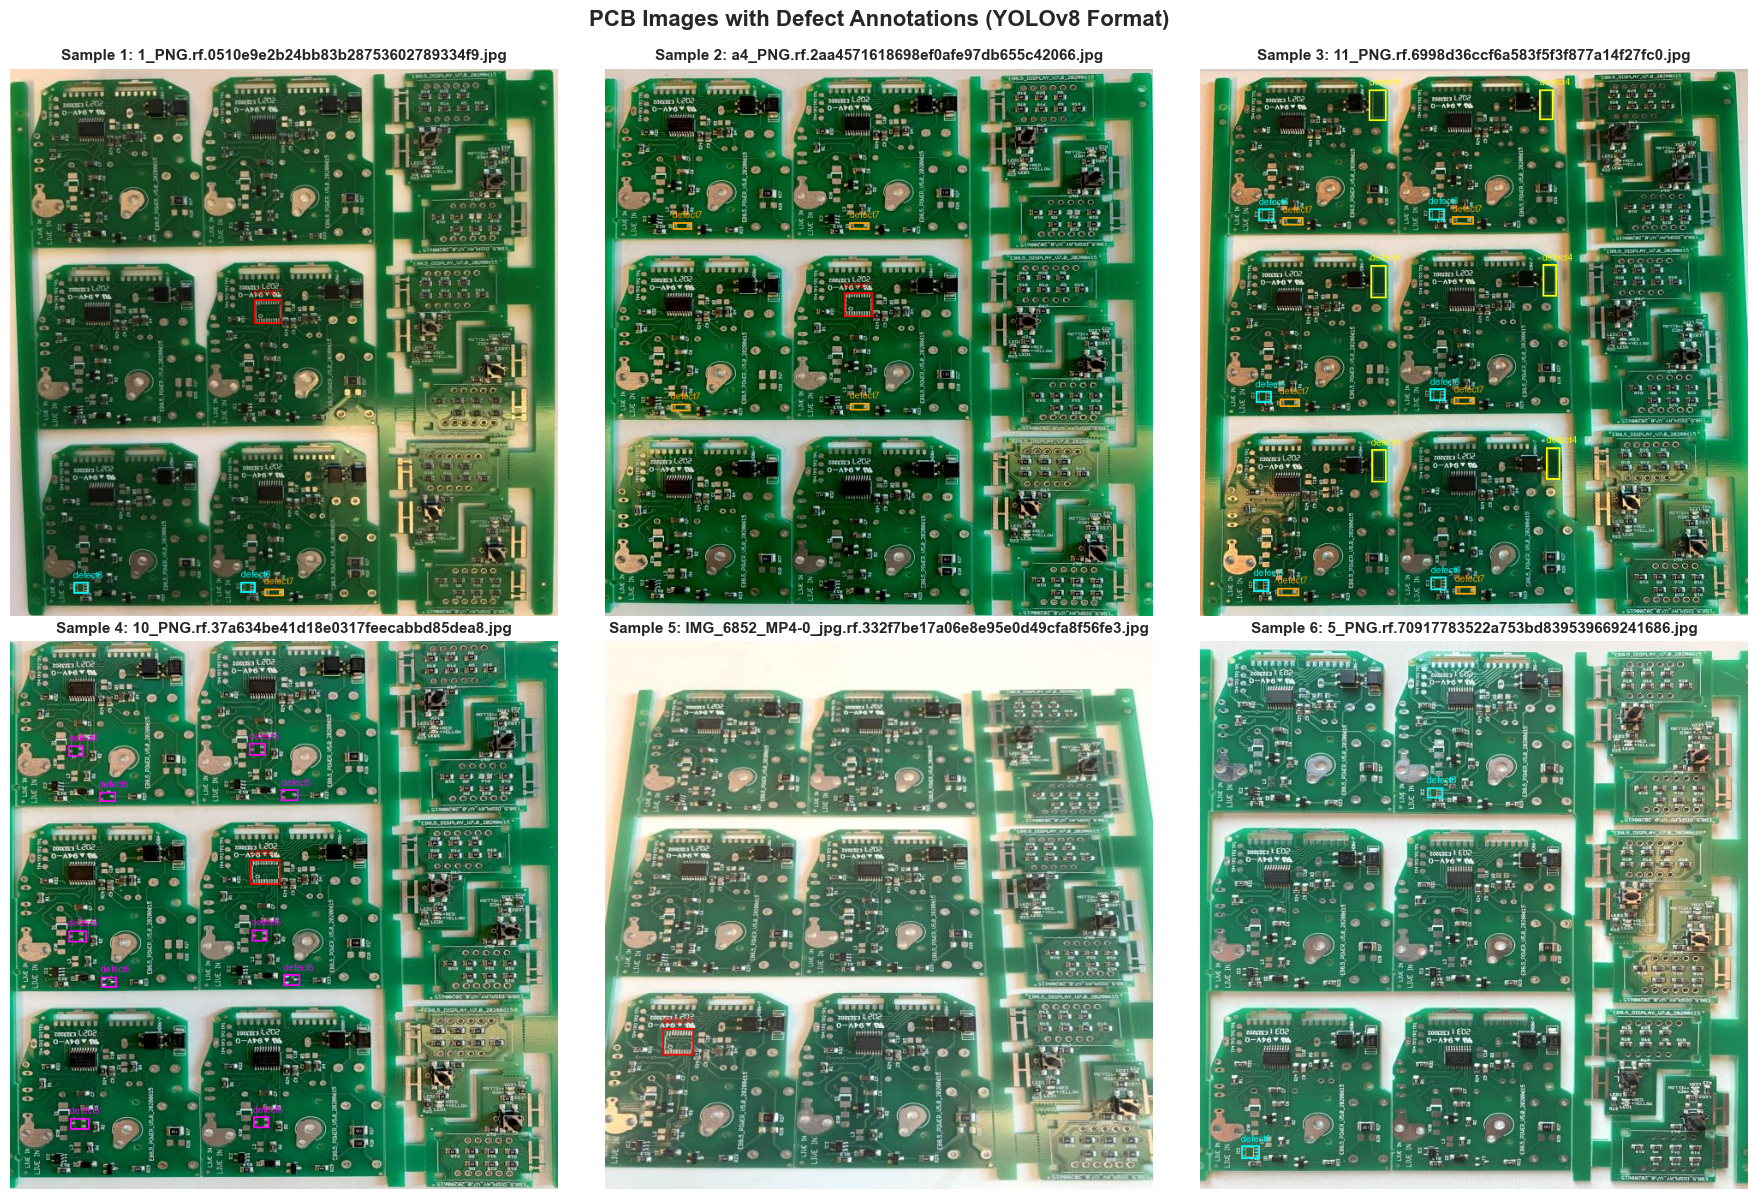

✅ Sample PCB images with bounding boxes displayed!


In [6]:
from pathlib import Path
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

DATA_ROOT = Path('../data/raw')
TRAIN_IMG = DATA_ROOT / 'train' / 'images'
TRAIN_LABELS = DATA_ROOT / 'train' / 'labels'

class_names = ['defect1', 'defect2', 'defect3', 'defect4', 'defect5', 'defect6', 'defect7']
colors_hex = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFA500']  # Red, Green, Blue, etc.

def draw_yolo_boxes(image_path, label_path, class_names, colors_hex):
    """
    Load image and draw YOLOv8 format bounding boxes on it
    Returns PIL Image with boxes drawn
    """
    img = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    img_width, img_height = img.size
    
    # Read label file
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                
                class_id = int(parts[0])
                # YOLO format: center_x, center_y, width, height (normalized 0-1)
                cx, cy, w, h = map(float, parts[1:5])
                
                # Convert from normalized to pixel coordinates
                x_center = cx * img_width
                y_center = cy * img_height
                box_width = w * img_width
                box_height = h * img_height
                
                # Calculate top-left and bottom-right corners
                x1 = x_center - box_width / 2
                y1 = y_center - box_height / 2
                x2 = x_center + box_width / 2
                y2 = y_center + box_height / 2
                
                # Draw rectangle
                color = colors_hex[class_id]
                draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
                
                # Draw class label
                label_text = class_names[class_id]
                draw.text((x1, y1 - 15), label_text, fill=color)
    
    return img

# Get list of all training images
all_train_images = list(TRAIN_IMG.glob('*.jpg')) + list(TRAIN_IMG.glob('*.png'))

# Randomly select 6 images to visualize
sample_images = random.sample(all_train_images, min(6, len(all_train_images)))

# Create a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(sample_images):
    label_path = TRAIN_LABELS / (img_path.stem + '.txt')
    
    # Draw boxes on image
    img_with_boxes = draw_yolo_boxes(img_path, label_path, class_names, colors_hex)
    
    # Display
    axes[idx].imshow(img_with_boxes)
    axes[idx].set_title(f'Sample {idx+1}: {img_path.name}', fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('PCB Images with Defect Annotations (YOLOv8 Format)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✅ Sample PCB images with bounding boxes displayed!")
